In [53]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.25' 

%matplotlib widget
import matplotlib.pyplot as plt

# Synthetic target: sum of two Gaussians at input plane, then fit
import jax
import jax.numpy as jnp
from temgym_core.components import Detector
from temgym_core.gaussian import GaussianRay, evaluate_gaussian_input_image

import optax


jax.config.update("jax_enable_x64", True)

[-0.000128  0.000128] [-0.000128  0.000128]


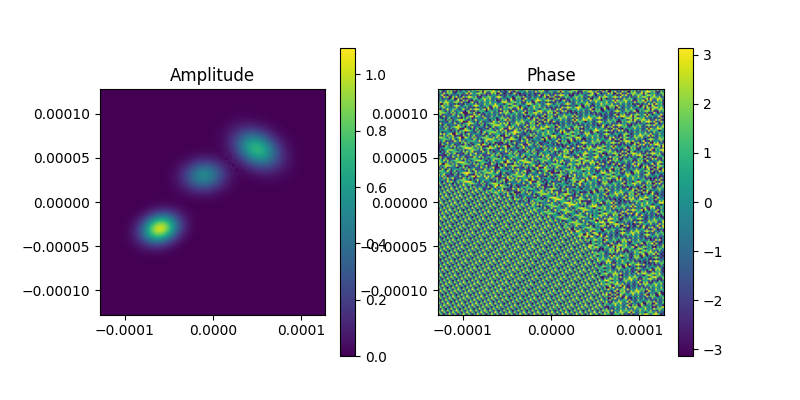

In [54]:
# Grid
H, W = 128, 128
px = (2e-6, 2e-6)
wl = 2.51e-12  # 200 keV approx
x_bounds = px[0] * jnp.array([-W // 2, W // 2])
y_bounds = px[1] * jnp.array([-H // 2, H // 2])

print(x_bounds, y_bounds)

scan = Detector(z=0.0, pixel_size=px, shape=(H, W))

# Build ground truth rays
N_gt = 3
amp = jnp.array([1.0, 0.7, 0.5])
pos = jnp.array([[-60e-6, -30e-6], [50e-6, 60e-6], [-10e-6, 30e-6]])
tilt = jnp.array([[2e-3, -1.5e-3], [-1e-3, 2e-3], [0.5e-3, -0.8e-3]])
waist = jnp.array([[20e-6, 15e-6], [25e-6, 18e-6], [22e-6, 16e-6]])
R = jnp.array([[jnp.inf, jnp.inf], [0.15, jnp.inf], [jnp.inf, 0.2]])
th = jnp.array([0.3, -0.5, 0.1])

rays_tgt = GaussianRay(
    x=pos[:, 0], y=pos[:, 1], dx=tilt[:, 0], dy=tilt[:, 1],
    z=jnp.zeros((N_gt,)), pathlength=jnp.zeros((N_gt,)),
    amplitude=amp, waist_xy=waist, radii_of_curv=R, wavelength=wl, theta=th,
    _one = jnp.ones((N_gt,))
)

# Target complex field at input plane
u_tgt = evaluate_gaussian_input_image(rays_tgt, scan)
amp_tgt = jnp.abs(u_tgt)
phase_tgt = jnp.angle(u_tgt)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
im0 = ax[0].imshow(amp_tgt, vmin=0, vmax=1.1 * amp_tgt.max(), extent=(x_bounds[0], x_bounds[1], y_bounds[0], y_bounds[1]))
ax[0].set_title('Amplitude')
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(phase_tgt, vmin=-jnp.pi, vmax=jnp.pi, extent=(x_bounds[0], x_bounds[1], y_bounds[0], y_bounds[1]))
ax[1].set_title('Phase')
fig.colorbar(im1, ax=ax[1])
plt.show()

In [55]:
initial_gaussian_rays = rays_tgt.derive(
    amplitude=jnp.array([0.9, 0.6, 0.4]),
    waist_xy=jnp.array([[20e-6, 15e-6], [25e-6, 18e-6], [22e-6, 16e-6]]),
)

# 1) Loss over a concrete (bounded) GaussianRay
def loss_rays(rays: GaussianRay):
    u_hat = evaluate_gaussian_input_image(rays, scan)
    amp_hat = jnp.abs(u_hat)
    amp_true = jnp.abs(u_tgt)
    return jnp.mean((amp_hat - amp_true) ** 2)

# Sanity check against the ground-truth rays
assert loss_rays(rays_tgt) < 1e-12

# Keep the original guess visualization
u_in = evaluate_gaussian_input_image(initial_gaussian_rays, scan)
amp_guess = jnp.abs(u_in)
phase_guess = jnp.angle(u_in)


In [63]:
guess = initial_gaussian_rays.derive(
    amplitude=jnp.ones((N_gt,)),
    waist_xy=jnp.full((N_gt, 2), 10e-6),
)


def unpack(trainable):
    # positivity + scaling for healthy conditioning
    amp = jnp.exp(trainable['amp_log'])             # shape (N_gt,)
    waist_xy = jnp.exp(trainable['waist_xy_log'])   # shape (N_gt, 2)

    # unit vector that represents [cos(2θ), sin(2θ)]
    u = trainable['theta_u']
    u = u / jnp.linalg.norm(u, axis=-1, keepdims=True)  # shape (N_gt, 2)
    theta = 0.5 * jnp.arctan2(u[...,1], u[...,0])       # back to θ

    return {'amplitude': amp, 'waist_xy': waist_xy, 'theta': theta}

def rays_from_trainable(trainable):
    return initial_gaussian_rays.derive(**unpack(trainable))

def loss_from_trainable(trainable):
    return loss_rays(rays_from_trainable(trainable))

# sensible init from an angle guess θ0
theta0 = rays_tgt.theta + 0.1
theta_u0 = jnp.stack([jnp.cos(2*theta0), jnp.sin(2*theta0)], axis=-1)

trainable_init = {
    'amp_log'      : jnp.log(jnp.clip(guess.amplitude, 1e-12, None)),
    'waist_xy_log' : jnp.log(jnp.clip(guess.waist_xy, 1e-12, None)),
    'theta_u'      : theta_u0,
}

optimizer = optax.lbfgs()
opt_state = optimizer.init(trainable_init)
value_and_grad = optax.value_and_grad_from_state(loss_from_trainable)

@jax.jit
def step(params, opt_state):
    val, grad = value_and_grad(params, state=opt_state)
    updates, opt_state = optimizer.update(
        grad, opt_state, params, value=val, grad=grad, value_fn=loss_from_trainable
    )
    params = optax.apply_updates(params, updates)
    return params, opt_state, val

num_steps = 10000
log_interval = 10

eps = 1e-12
params = trainable_init
prev_loss = None
for i in range(num_steps):
    params, opt_state, l = step(params, opt_state)
    loss_val = float(l)
    if (i + 1) % log_interval == 0:
        print(f"Step {i+1}, Loss: {loss_val:.6e}")

    if prev_loss is not None:
        if abs(loss_val - prev_loss) <= eps:
            if 'stable_count' not in locals():
                stable_count = 1
            else:
                stable_count += 1
            if stable_count >= 100:
                print(f"Early stopping at step {i+1}: Δloss remained ≤ {eps} for 100 steps")
                break
        else:
            stable_count = 0
    prev_loss = loss_val

rays = rays_from_trainable(params)

Step 10, Loss: 3.677429e-05
Step 20, Loss: 2.103380e-05
Step 30, Loss: 7.388562e-06
Step 40, Loss: 5.652170e-06
Step 50, Loss: 5.147344e-06
Step 60, Loss: 4.293871e-06
Step 70, Loss: 4.035029e-06
Step 80, Loss: 3.958520e-06
Step 90, Loss: 3.934875e-06
Step 100, Loss: 3.914478e-06
Step 110, Loss: 3.904613e-06
Step 120, Loss: 3.903703e-06
Step 130, Loss: 3.903606e-06
Step 140, Loss: 3.903542e-06
Step 150, Loss: 3.903452e-06
Step 160, Loss: 3.903432e-06
Step 170, Loss: 3.903416e-06
Step 180, Loss: 3.903415e-06
Step 190, Loss: 3.903414e-06
Step 200, Loss: 3.903414e-06
Step 210, Loss: 3.903414e-06
Step 220, Loss: 3.903414e-06
Step 230, Loss: 3.903414e-06
Step 240, Loss: 3.903414e-06
Step 250, Loss: 3.903414e-06
Step 260, Loss: 3.903414e-06
Step 270, Loss: 3.903414e-06
Step 280, Loss: 3.903414e-06
Step 290, Loss: 3.903414e-06
Step 300, Loss: 3.903414e-06
Step 310, Loss: 3.903414e-06
Step 320, Loss: 3.903414e-06
Step 330, Loss: 3.903414e-06
Step 340, Loss: 3.903414e-06
Step 350, Loss: 3.90341

In [64]:
# Compare the fit parameters to the ground truth
print("Fitted parameters vs Ground truth:")
print(f"Amplitude:\n  Ground truth: {rays_tgt.amplitude}\n  Fitted:      {rays.amplitude}\n")
print(f"Waist (xy):\n  Ground truth:\n{rays_tgt.waist_xy}\n  Fitted:\n{rays.waist_xy}\n")
print(f"Theta:\n  Ground truth: {rays_tgt.theta}\n  Fitted:      {rays.theta}")

Fitted parameters vs Ground truth:
Amplitude:
  Ground truth: [1.  0.7 0.5]
  Fitted:      [1.00002388 0.70049448 0.50078067]

Waist (xy):
  Ground truth:
[[2.0e-05 1.5e-05]
 [2.5e-05 1.8e-05]
 [2.2e-05 1.6e-05]]
  Fitted:
[[1.99994030e-05 1.49996711e-05]
 [2.49705382e-05 1.79874146e-05]
 [2.19091701e-05 1.59972739e-05]]

Theta:
  Ground truth: [ 0.3 -0.5  0.1]
  Fitted:      [ 0.29991772 -0.45762686  0.14322061]


Text(0.5, 1.0, 'Fitted Amplitude')

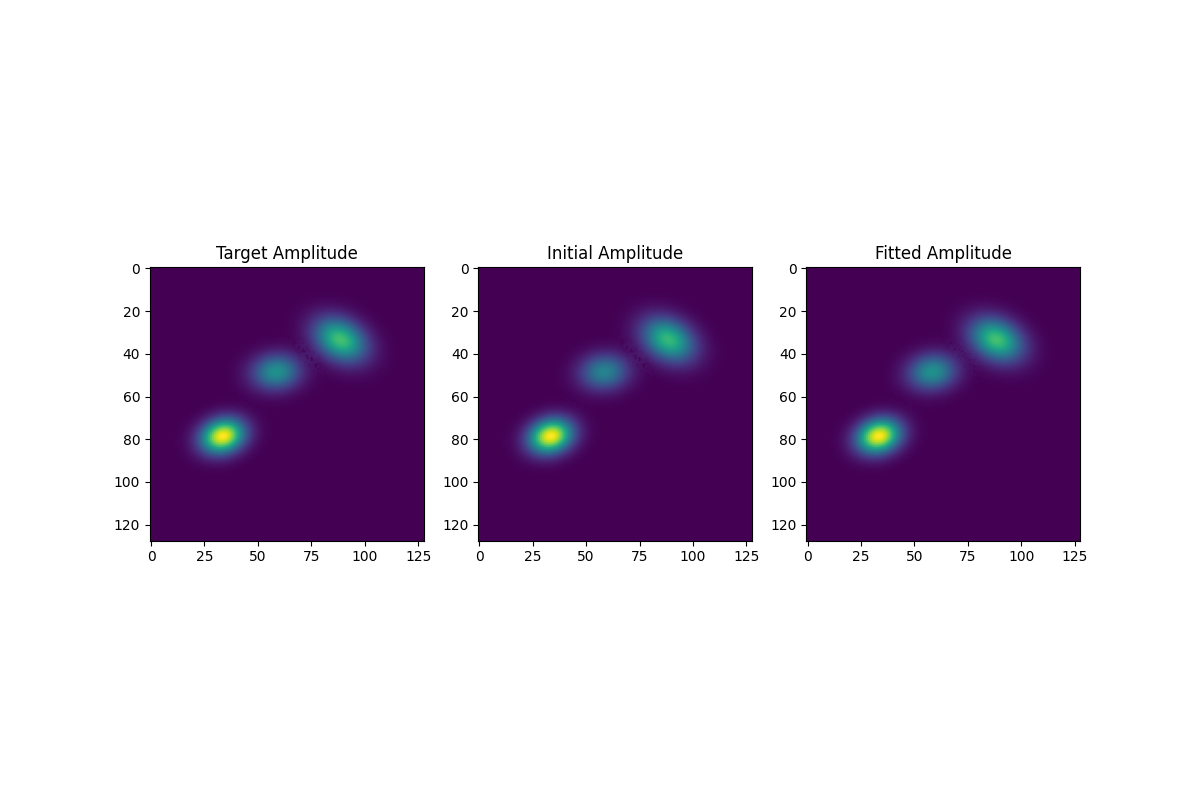

In [65]:

# Final field
u_fit = evaluate_gaussian_input_image(rays, scan)
amp_fit = jnp.abs(u_fit)

fig, ax = plt.subplots(1, 3, figsize=(12, 8))
im0 = ax[0].imshow(amp_tgt)
ax[0].set_title('Target Amplitude')
im1 = ax[1].imshow(amp_guess)
ax[1].set_title('Initial Amplitude')
im2 = ax[2].imshow(amp_fit)
ax[2].set_title('Fitted Amplitude')